<a href="https://colab.research.google.com/github/katarinagresova/M7DataSP_2020/blob/master/assignment_08/G_quadruplexes_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was created for classification of G-quadruplexes, which was part of [assignment 08](https://github.com/simecek/dspracticum2020/tree/master/lecture_08/assignment) in subject [Data Science Practicum 2020](https://github.com/simecek/dspracticum2020). Most of the code was taken from [G4_benchmark notebook](https://github.com/simecek/dspracticum2020/blob/master/lecture_08/assignment/g4/G4_benchmark.ipynb).

Several architectures were tried, but the best results were from model created by concatenating cnn model and lstm model.

#Setup

In [1]:
!pip install biopython

     |████████████████████████████████| 2.3MB 21.2MB/s 


In [2]:
import urllib.request
from pathlib import Path
from Bio import SeqIO
import numpy as np
import gzip

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Reshaping data from fasta to txt


In [3]:
classes = ['notpresent', 'present']
sets = ['train', 'valid']

for c in classes:
    for s in sets:
        urllib.request.urlretrieve(f"https://github.com/simecek/dspracticum2020/raw/master/lecture_08/assignment/g4/g4_{c}_{s}.fa.gz", f"g4_{c}_{s}.fa.gz")

In [4]:
for c in classes:
    for s in sets:
        Path(f"data/{s}/{c}").mkdir(parents=True, exist_ok=True)

In [5]:
counter = {}
for c in classes:
    counter[c] = 0
    for s in sets:
        with gzip.open(f"g4_{c}_{s}.fa.gz", "rt") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                counter[c] += 1
                id = record.id
                with open(f"data/{s}/{c}/{id}.txt", "w") as fw:
                    fw.writelines([" ".join(str(record.seq))])

for s in counter:
  print(f"Found {counter[s]} records of class {s}")

Found 150000 records of class notpresent
Found 150000 records of class present


So we are working with balanced dataset.

#Reading data

In [15]:
batch_size = 512

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/train/',
    batch_size=batch_size,
    class_names=classes)

Found 210000 files belonging to 2 classes.


In [16]:
raw_valid_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/valid/',
    batch_size=batch_size,
    class_names=classes)

Found 90000 files belonging to 2 classes.


In [17]:
vectorize_layer = TextVectorization(output_mode='int')

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
vectorize_layer.set_vocabulary(vocab=np.asarray(['a', 'c', 't', 'g', 'n']))

In [22]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text)-2, label

train_ds = raw_train_ds.map(vectorize_text)
valid_ds = raw_valid_ds.map(vectorize_text)

In [27]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Model training

In [23]:
# one-hot encoding
onehot_layer = keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x,'int64'), 4))

In [24]:
# model one hot encoded
model_cnn_lstm = tf.keras.Sequential([
    onehot_layer,
    keras.layers.Conv1D(32, kernel_size=6, data_format='channels_last', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(16, kernel_size=6, data_format='channels_last', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(4, kernel_size=6, data_format='channels_last', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")
])
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])





In [25]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0.9, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [26]:
epochs = 10
history = model_cnn_lstm.fit(
    train_ds,
    epochs=epochs,
    validation_data = valid_ds)

Epoch 1/10
411/411 [==============================] - 102s 248ms/step - loss: 0.1378 - accuracy: 0.9467 - val_loss: 0.1968 - val_accuracy: 0.9194
Epoch 2/10
411/411 [==============================] - 98s 239ms/step - loss: 0.1000 - accuracy: 0.9630 - val_loss: 0.0983 - val_accuracy: 0.9636
Epoch 3/10
411/411 [==============================] - 95s 231ms/step - loss: 0.0924 - accuracy: 0.9657 - val_loss: 0.0949 - val_accuracy: 0.9653
Epoch 4/10
411/411 [==============================] - 95s 231ms/step - loss: 0.0866 - accuracy: 0.9675 - val_loss: 0.0902 - val_accuracy: 0.9667
Epoch 5/10
411/411 [==============================] - 98s 238ms/step - loss: 0.0834 - accuracy: 0.9687 - val_loss: 0.1026 - val_accuracy: 0.9618
Epoch 6/10
411/411 [==============================] - 99s 240ms/step - loss: 0.0812 - accuracy: 0.9699 - val_loss: 0.0985 - val_accuracy: 0.9625
Epoch 7/10
411/411 [==============================] - 95s 231ms/step - loss: 0.0789 - accuracy: 0.9704 - val_loss: 0.0918 - val_a

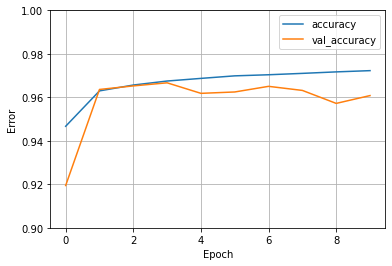

In [28]:
plot_accuracy(history)

In [29]:
# model one hot encoded
model_cnn_lstm1 = tf.keras.Sequential([
    keras.layers.Embedding(5, 32, input_length=200),
    keras.layers.Conv1D(32, kernel_size=6, data_format='channels_last', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(16, kernel_size=6, data_format='channels_last', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(4, kernel_size=6, data_format='channels_last', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(128, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")
])
model_cnn_lstm1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m])





In [30]:
epochs = 10
history = model_cnn_lstm1.fit(
    train_ds,
    epochs=epochs,
    validation_data = valid_ds)

Epoch 1/10
411/411 [==============================] - 93s 226ms/step - loss: 0.1219 - accuracy: 0.9543 - f1_m: 0.9541 - val_loss: 0.5500 - val_accuracy: 0.6741 - val_f1_m: 0.7526
Epoch 2/10
411/411 [==============================] - 83s 203ms/step - loss: 0.0954 - accuracy: 0.9645 - f1_m: 0.9645 - val_loss: 0.0992 - val_accuracy: 0.9627 - val_f1_m: 0.9624
Epoch 3/10
411/411 [==============================] - 89s 217ms/step - loss: 0.0885 - accuracy: 0.9666 - f1_m: 0.9666 - val_loss: 0.0961 - val_accuracy: 0.9648 - val_f1_m: 0.9642
Epoch 4/10
411/411 [==============================] - 88s 214ms/step - loss: 0.0845 - accuracy: 0.9687 - f1_m: 0.9686 - val_loss: 0.0923 - val_accuracy: 0.9663 - val_f1_m: 0.9656
Epoch 5/10
411/411 [==============================] - 81s 198ms/step - loss: 0.0809 - accuracy: 0.9698 - f1_m: 0.9697 - val_loss: 0.0787 - val_accuracy: 0.9708 - val_f1_m: 0.9707
Epoch 6/10
411/411 [==============================] - 83s 202ms/step - loss: 0.0788 - accuracy: 0.9704 - 

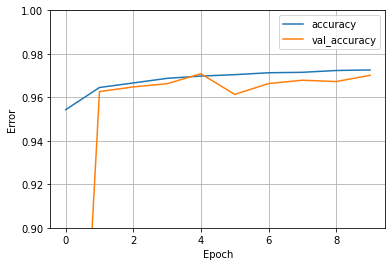

In [31]:
plot_accuracy(history)